In [2]:
import pandas as pd
import sys
sys.path.append('..')  # Adjust the path based on your project structure
import json
import re
import ast
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay,  average_precision_score
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
from miga.const import ID2LABELS_SMG_SHORT as ID2LABELS

import datetime

In [3]:
from pathlib import Path
def load_and_parse_txt(path_or_list, feature_names, file_names):
    # Read the text file into a list of lines
    if isinstance(path_or_list, list):
        
        df_list = []
        logit_columns_list = []
        pred_columns_list = []
        gt_columns_list = []
        for p in path_or_list:
            df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(p, feature_names, file_names)
            df_list.append(df)
            logit_columns_list.append(logit_columns)
            pred_columns_list.append(pred_columns)
            gt_columns_list.append(gt_columns)
        return pd.concat(df_list), logit_columns_list, pred_columns_list, gt_columns_list
    elif isinstance(path_or_list, str):
        path = path_or_list

    with open(path, 'r') as file:
        lines = file.readlines()
    


    # Extract relevant information from each line
    data = []
    indecies = []
    TH = 0.4
    for line in lines[1:]:

        
        # Use regex to find index, predictions, and targets
        # match = re.match(r'(\d+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        # match = re.match(r'(\d+\-[^ ]+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        if match:
    

            # index = int(match.group(1))
            index = match.group(1)
            
            # Extract model predictions and convert to list using ast
            logits_str = match.group(2)
            logits = list(ast.literal_eval(logits_str))
            
            predictions = ((np.array(logits)>TH).astype(int)).tolist()


            # Extract targets and convert to list using ast
            targets_str = f'[{match.group(3)}]'
            targets = list(np.array(ast.literal_eval(targets_str)))

            
            row_data = logits + predictions + targets 
            row_data = np.array(row_data)
            data.append(row_data)
            # indecies.append(int(index))
            indecies.append(index)

    # Create column names
    logit_columns = [f"logit-{name}" for name in feature_names]
    pred_columns = [f"pred-{name}" for name in feature_names]
    gt_columns = [f"gt-{name}" for name in feature_names]
    columns = logit_columns + pred_columns + gt_columns 

    # Create Pandas DataFrame
    df = pd.DataFrame(data, columns=columns, index=indecies)
    df[pred_columns+gt_columns] = df[pred_columns+gt_columns].astype(int)
    # print(df.iloc[0])
    # print(df.tail(1))
    df['filenames'] = file_names
    df['log_name'] = osp.basename(path)

    return df, logit_columns, pred_columns, gt_columns
    # return data, columns
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)

In [4]:
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction'
# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_multi'

# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8'
# run_name = 'eval_on_original'
# 'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\eval after downsampleing'
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments'
run_name = 'resampled_64_multi_update_freq_8'

In [5]:
# path_to_weights = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_001/dataset/weights.json'
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_5vid_clean'
# run_name = 'videomae_vit_base_patch16_224_tubemasking_ratio_0.9_kinetic_400'
path_to_weights = osp.join(experiment_folder,run_name,'dataset','weights.json')
with open(path_to_weights, 'r') as json_file:
    positive_weights_dict = json.load(json_file)

        
feature_names = [entry['class'] for entry in positive_weights_dict['data']]

In [6]:
feature_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [7]:
# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval','*.txt'))
# # path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')

# path_to_log = glob(osp.join(experiment_folder,run_name,'','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval after downsampleing','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'validation_best_after_100_epochs','*.txt'))
path_to_log = glob(osp.join(experiment_folder,run_name,'delete_later','*.txt'))


# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')



# Get names of file names from the csv file
df_csv = pd.read_csv(path_to_dataset)
file_names = df_csv['filenames'].tolist()
metadata = df_csv['metadata'].tolist()
df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,'')
# data, columns = load_and_parse_txt(path_to_log, feature_names)
df = df.drop(columns='log_name').groupby('filenames').mean()
logit_columns=logit_columns[0]
pred_columns=pred_columns[0]
gt_columns=gt_columns[0]

In [8]:
np.max(df[logit_columns].values, axis=1)

array([0.89453125, 0.94091797, 0.96484375, 0.96044922, 0.98974609,
       0.53857422, 0.99365234, 0.99804688, 0.99121094, 0.79248047,
       0.53173828, 0.97314453, 0.47583008, 0.26879883, 0.58496094,
       0.95361328, 0.99121094, 0.99707031, 0.97998047, 0.99853516,
       0.72167969, 0.625     , 0.36132812, 0.51220703, 0.80371094,
       0.96875   , 0.96386719, 0.94140625, 0.90478516, 0.87255859,
       0.98486328, 0.99755859, 0.98925781, 0.31176758, 0.83398438,
       0.99414062, 0.96875   , 0.99804688, 0.71826172, 0.99267578,
       0.88720703, 0.06878662, 0.46289062, 0.99853516, 0.93554688,
       0.27563477, 0.94824219, 0.99902344, 0.9375    , 0.99462891,
       0.99853516, 0.98876953, 0.99902344, 0.99853516, 0.96630859,
       0.99267578, 0.38134766, 0.99414062, 0.95800781, 0.92431641,
       0.95507812, 0.36743164, 0.96240234, 0.74951172, 0.83300781,
       0.97412109, 0.97363281, 0.93505859, 0.97705078, 0.86816406,
       0.98242188, 0.25830078, 0.68896484, 0.73388672, 0.68408

In [9]:
df

,logit-0,logit-1,logit-2,logit-3,logit-4,logit-5,logit-6,logit-7,logit-8,logit-9,...,gt-7,gt-8,gt-9,gt-10,gt-11,gt-12,gt-13,gt-14,gt-15,gt-16
filenames,,,,,,,,,,,,,,,,,,,,,
0001_000_00164-00228_14.mp4,0.000099,0.009193,0.001320,0.000421,0.001803,0.000038,0.000191,0.000741,0.894531,0.000005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0001_003_04835-04899_11.mp4,0.000083,0.116577,0.002714,0.000121,0.000323,0.001782,0.000527,0.004215,0.103210,0.000024,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0001_005_06437-06501_8.mp4,0.000843,0.000103,0.001184,0.000095,0.001919,0.000070,0.000072,0.080383,0.964844,0.000028,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001_007_06547-06611_8.mp4,0.000223,0.000028,0.000411,0.000283,0.002132,0.000028,0.000062,0.001567,0.960449,0.000027,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001_009_06620-06684_8.mp4,0.000077,0.000018,0.001330,0.000631,0.001681,0.000043,0.000220,0.001053,0.989746,0.000021,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0018_074_16872-16936_9.mp4,0.000091,0.000484,0.000869,0.000117,0.015961,0.000427,0.347168,0.006313,0.002010,0.500000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0019_013_02956-03020_7-4.mp4,0.000012,0.009857,0.000519,0.000573,0.039429,0.006363,0.000217,0.874023,0.000962,0.000690,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0020_000_00609-00673_5-11.mp4,0.000218,0.070190,0.264893,0.001048,0.021622,0.888672,0.004250,0.000193,0.002378,0.000712,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:


df['side'] = df.index.str.split('/').str[-2]
df['camera_name'] = df.index.str.split('/').str[-3]
df['view'] = df['camera_name'].apply(lambda x: 'top' if x == 'Cam3' else 'front' if x == 'Cam4' else None)

In [10]:
# # print(sum(df['gt-lgcr']))
# # print(len(df))
# # th = 0.5
# # print(sum(df['logit-lgcr']>th))
# df.loc[(df['gt-lgcr']==0) & (df['logit-lgcr']>th)][['gt-lgcr','logit-lgcr']]

In [11]:
# df['time_second'] = df.index.str.split('/').str[-1].str.split('.').str[0].astype(int) * 2
# df['time_minutes'] = df['time_second'].apply(lambda x: str(datetime.timedelta(seconds=x)))


In [12]:
# fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/left/0092.mp4'
# partial_fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/'
# time_range = [57, 70]
# columns_to_check = ['gt-lgcr','logit-lgcr']
# df.loc[(df.index.str.contains(partial_fname))&(df['time_second']>time_range[0])&(df['time_second']<=time_range[1])][columns_to_check]

In [13]:
df.to_csv(osp.join(experiment_folder, run_name, 'raw_test_results.csv'))

In [91]:
# Summarize metrics using classification report
def generate_report(df_in, th=None):
    
    def get_scores(metric_name, metric_function):

        average_metric = dict()
        for class_name in y_true_df.columns:
            
            y_true = gt[class_name].values
            y_pred = logits[class_name.replace('gt','logit')].values
            ap = metric_function(y_true, y_pred)
            average_metric[int(class_name.replace('gt-',''))]= ap
        
        avg_types = ['micro', 'samples', 'weighted', 'macro']
        metric_df = dict()
        for avg_type in avg_types:
            metric_df[avg_type+' avg'] = metric_function(gt, logits,average=avg_type)
        average_metric.update(metric_df)
        average_metric_df = pd.DataFrame(average_metric.values(), index=average_metric.keys(), columns=[metric_name])
        return average_metric_df
    
    df = df_in.copy()
    if th is not None:
        if isinstance(th,float):
            th_dict = {k:th for k in range(len(feature_names))} 
        elif isinstance(th, dict):
            th_dict = th
        
        for k, v in th_dict.items():
            df['pred-'+str(k)] = df['logit-'+str(k)] >= v
    else:
        th_dict = {k:np.nan for k in range(len(feature_names))}
        
    gt = df[gt_columns]
    predictions = df[pred_columns]
    logits = df[logit_columns]
    

    classification_rep = classification_report(gt, predictions, output_dict=True, target_names=feature_names)
    df_report = pd.DataFrame.from_dict(classification_rep).transpose()
    def id_to_labels(x):
        try:
            x = int(x)
        except:
            return x
        return ID2LABELS[x+1]
    df_ap = get_scores(metric_name='AP', metric_function=average_precision_score)
    df_auc = get_scores(metric_name='AUC', metric_function=roc_auc_score)
    df_th = pd.DataFrame(th_dict.values(), index=th_dict.keys(), columns=['threshold'])
    df_report = df_report.join(df_ap).join(df_auc).join(df_th)
    
    
    
    
    df_report['labels'] = df_report.reset_index()['index'].apply(id_to_labels)
    

    # add auc
    # Calculate ROC-AUC for each label
    roc_auc_scores = {}
    roc_metrics = {}
    
    feature_names_str = [str(a) for a in feature_names]
    for column in feature_names_str:
        
        true_label = gt['gt-'+column]
        pred_prob = logits['logit-'+column]
        roc_auc = roc_auc_score(true_label, pred_prob)
        roc_auc_scores[int(column)] = roc_auc
        fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
        roc_metrics[column] = dict(
            fpr=fpr,
            tpr=tpr,
            thresholds=thresholds,
            auc = roc_auc
        )
    
    
    return df_report, logits, gt

df_report, logits, gt = generate_report(df, th=optimal_th_dict)

# df_report['view'] = 'center'

# df_top = df[df['view'] == 'top']
# df_report_top, logits_top, gt_top = generate_report(df_top)
# df_report_top['view'] = 'top'
# 
# df_front = df[df['view'] == 'front']
# df_report_front, logits_front, gt_front = generate_report(df_front)
# df_report_front['view'] = 'front'



In [92]:
df_report

,precision,recall,f1-score,support,AP,AUC,threshold,labels
0,0.272727,1.000000,0.428571,6.0,0.531566,0.985196,0.037201,Turtling neck
1,0.135593,1.000000,0.238806,8.0,0.404756,0.961455,0.030792,Rubbing face
2,0.848485,0.965517,0.903226,29.0,0.967115,0.995875,0.106689,Folding arms
3,0.500000,1.000000,0.666667,2.0,0.750000,0.997167,0.203857,Touching chest
4,0.935185,0.909910,0.922374,111.0,0.969229,0.983514,0.096863,Moving legs
5,0.384615,1.000000,0.555556,5.0,0.726923,0.992571,0.029587,Scratching neck
6,0.414634,1.000000,0.586207,17.0,0.797869,0.983815,0.003855,Arms behind
7,0.545455,0.913043,0.682927,46.0,0.802176,0.961024,0.006641,Rubbing hands
8,0.881356,0.866667,0.873950,120.0,0.925107,0.952890,0.207031,Arms akimbo
9,1.000000,1.000000,1.000000,2.0,1.000000,1.000000,0.500000,Crossing legs


In [155]:
# df_concat = pd.concat([df_report,df_report_top,df_report_front], axis=0)
# df_concat_f1 = df_concat[['f1-score','view']].pivot(columns=['view'])
# df_concat_f1['support'] = df_report['support']

In [156]:
# df_concat_f1.sort_values(by=['support'])

In [18]:
feature_names_str = [str(a) for a in feature_names]

In [31]:
# Calculate ROC-AUC for each label
roc_auc_scores = {}
roc_metrics = {}

for column in feature_names_str:
    
    true_label = gt['gt-'+column]
    pred_prob = logits['logit-'+column]
    roc_auc = roc_auc_score(true_label, pred_prob)
    roc_auc_scores[int(column)] = roc_auc
    fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
    roc_metrics[column] = dict(
        fpr=fpr,
        tpr=tpr,
        thresholds=thresholds,
        auc = roc_auc
    )


# Display ROC-AUC scores for each label
for label, roc_auc in roc_auc_scores.items():
    print(f'ROC-AUC for {label}: {roc_auc}')

ROC-AUC for 0: 0.9851957975167145
ROC-AUC for 1: 0.9614553314121036
ROC-AUC for 2: 0.9958747620055002
ROC-AUC for 3: 0.9971671388101983
ROC-AUC for 4: 0.983514251956875
ROC-AUC for 5: 0.9925714285714285
ROC-AUC for 6: 0.9838148277062305
ROC-AUC for 7: 0.9610243421978331
ROC-AUC for 8: 0.9528900709219859
ROC-AUC for 9: 1.0
ROC-AUC for 10: 0.9971671388101983
ROC-AUC for 11: 0.9435688597419081
ROC-AUC for 12: 0.9920749279538905
ROC-AUC for 13: 0.9640579710144928
ROC-AUC for 14: 0.5474504249291785
ROC-AUC for 15: 0.9586894586894588
ROC-AUC for 16: 0.9667487684729065


In [32]:
roc_auc_scores

{0: 0.9851957975167145,
 1: 0.9614553314121036,
 2: 0.9958747620055002,
 3: 0.9971671388101983,
 4: 0.983514251956875,
 5: 0.9925714285714285,
 6: 0.9838148277062305,
 7: 0.9610243421978331,
 8: 0.9528900709219859,
 9: 1.0,
 10: 0.9971671388101983,
 11: 0.9435688597419081,
 12: 0.9920749279538905,
 13: 0.9640579710144928,
 14: 0.5474504249291785,
 15: 0.9586894586894588,
 16: 0.9667487684729065}

In [48]:
roc_values =  list(roc_auc_scores.values()) + [np.nan]* (len(df_report)-len(roc_auc_scores.values()))
df_report['auc'] = roc_values
df_report

,precision,recall,f1-score,support,labels,auc
0,0.400000,0.666667,0.500000,6.0,Turtling neck,0.985196
1,0.318182,0.875000,0.466667,8.0,Rubbing face,0.961455
2,0.961538,0.862069,0.909091,29.0,Folding arms,0.995875
3,1.000000,0.500000,0.666667,2.0,Touching chest,0.997167
4,0.968085,0.819820,0.887805,111.0,Moving legs,0.983514
5,0.666667,0.400000,0.500000,5.0,Scratching neck,0.992571
6,0.857143,0.705882,0.774194,17.0,Arms behind,0.983815
7,0.848485,0.608696,0.708861,46.0,Rubbing hands,0.961024
8,0.923077,0.800000,0.857143,120.0,Arms akimbo,0.952890
9,1.000000,1.000000,1.000000,2.0,Crossing legs,1.000000


In [71]:
df_ruc = pd.DataFrame.from_dict(roc_metrics).transpose()
optimal_th_inds = [np.argmax(a) for a in (df_ruc['tpr'].values - df_ruc['fpr'].values)]
th = df_ruc['thresholds'].values
optimal_th = [a[t] for t, a in zip(optimal_th_inds, th)]
optimal_th_dict = {n:opt for n,opt in zip(feature_names, optimal_th)}
optimal_th_dict


{0: 0.037200927734375,
 1: 0.030792236328125,
 2: 0.106689453125,
 3: 0.203857421875,
 4: 0.09686279296875,
 5: 0.0295867919921875,
 6: 0.0038547515869140625,
 7: 0.006641387939453125,
 8: 0.20703125,
 9: 0.5,
 10: 0.272705078125,
 11: 0.257080078125,
 12: 0.203857421875,
 13: 0.1207275390625,
 14: 0.00011962652206420898,
 15: 0.001926422119140625,
 16: 0.85595703125}

In [161]:
optimal_th

[0.037200927734375,
 0.030792236328125,
 0.106689453125,
 0.203857421875,
 0.09686279296875,
 0.0295867919921875,
 0.0038547515869140625,
 0.006641387939453125,
 0.20703125,
 0.5,
 0.272705078125,
 0.257080078125,
 0.203857421875,
 0.1207275390625,
 0.00011962652206420898,
 0.001926422119140625,
 0.85595703125]

In [77]:
optimal_preds = df.copy()
for column in feature_names_str:
    pred_prob = logits['logit-'+column]
    pred = pred_prob>optimal_th_dict[int(column)]
    optimal_preds['pred-'+column] = pred.astype(int)
df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)


In [80]:
optimal_th_dict

{0: 0.037200927734375,
 1: 0.030792236328125,
 2: 0.106689453125,
 3: 0.203857421875,
 4: 0.09686279296875,
 5: 0.0295867919921875,
 6: 0.0038547515869140625,
 7: 0.006641387939453125,
 8: 0.20703125,
 9: 0.5,
 10: 0.272705078125,
 11: 0.257080078125,
 12: 0.203857421875,
 13: 0.1207275390625,
 14: 0.00011962652206420898,
 15: 0.001926422119140625,
 16: 0.85595703125}

In [78]:
df_optimal_preds

,logit-0,logit-1,logit-2,logit-3,logit-4,logit-5,logit-6,logit-7,logit-8,logit-9,...,gt-10,gt-11,gt-12,gt-13,gt-14,gt-15,gt-16,side,camera_name,view
filenames,,,,,,,,,,,,,,,,,,,,,
0001_000_00164-00228_14.mp4,0.000099,0.009193,0.001320,0.000421,0.001803,0.000038,0.000191,0.000741,0.894531,0.000005,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0001_003_04835-04899_11.mp4,0.000083,0.116577,0.002714,0.000121,0.000323,0.001782,0.000527,0.004215,0.103210,0.000024,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None
0001_005_06437-06501_8.mp4,0.000843,0.000103,0.001184,0.000095,0.001919,0.000070,0.000072,0.080383,0.964844,0.000028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None
0001_007_06547-06611_8.mp4,0.000223,0.000028,0.000411,0.000283,0.002132,0.000028,0.000062,0.001567,0.960449,0.000027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None
0001_009_06620-06684_8.mp4,0.000077,0.000018,0.001330,0.000631,0.001681,0.000043,0.000220,0.001053,0.989746,0.000021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0018_074_16872-16936_9.mp4,0.000091,0.000484,0.000869,0.000117,0.015961,0.000427,0.347168,0.006313,0.002010,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None
0019_013_02956-03020_7-4.mp4,0.000012,0.009857,0.000519,0.000573,0.039429,0.006363,0.000217,0.874023,0.000962,0.000690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None
0020_000_00609-00673_5-11.mp4,0.000218,0.070190,0.264893,0.001048,0.021622,0.888672,0.004250,0.000193,0.002378,0.000712,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None


In [79]:
df_report_optimal, logits, gt = generate_report(df, th=optimal_th_dict)
df_report_optimal

C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,AP,AUC,labels
0,0.238095,0.833333,0.370370,6.0,0.531566,0.985196,Turtling neck
1,0.120690,0.875000,0.212121,8.0,0.404756,0.961455,Rubbing face
2,0.843750,0.931034,0.885246,29.0,0.967115,0.995875,Folding arms
3,0.333333,0.500000,0.400000,2.0,0.750000,0.997167,Touching chest
4,0.934579,0.900901,0.917431,111.0,0.969229,0.983514,Moving legs
5,0.333333,0.800000,0.470588,5.0,0.726923,0.992571,Scratching neck
6,0.400000,0.941176,0.561404,17.0,0.797869,0.983815,Arms behind
7,0.539474,0.891304,0.672131,46.0,0.802176,0.961024,Rubbing hands
8,0.880342,0.858333,0.869198,120.0,0.925107,0.952890,Arms akimbo
9,1.000000,0.500000,0.666667,2.0,1.000000,1.000000,Crossing legs


In [73]:
classification_rep = classification_report(gt, df_optimal_preds, output_dict=True, target_names=feature_names)
df_report = pd.DataFrame.from_dict(classification_rep).transpose()
# index_mapping = {str(idx): feature_name for idx, feature_name in enumerate(FEATURE_NAMES)}
# df_report.rename(index=index_mapping, inplace=True)
df_report.sort_values(by='support')
df_report = df_report.rename(index={a:f'{a:02}-{ID2LABELS[int(a)+1]}' for a in df_report.index if isinstance(a,int)})
df_report

C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
00-Turtling neck,0.238095,0.833333,0.370370,6.0
01-Rubbing face,0.120690,0.875000,0.212121,8.0
02-Folding arms,0.843750,0.931034,0.885246,29.0
03-Touching chest,0.333333,0.500000,0.400000,2.0
04-Moving legs,0.934579,0.900901,0.917431,111.0
05-Scratching neck,0.333333,0.800000,0.470588,5.0
06-Arms behind,0.400000,0.941176,0.561404,17.0
07-Rubbing hands,0.539474,0.891304,0.672131,46.0
08-Arms akimbo,0.880342,0.858333,0.869198,120.0
09-Crossing legs,1.000000,0.500000,0.666667,2.0


In [165]:
from mean_average_precision import MetricBuilder
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, auc

y_true_df = df[gt_columns]
y_pred_df = df[logit_columns]

# Calculate the average precision for each class
average_precisions = []
for class_name in y_true_df.columns:
    
    y_true = y_true_df[class_name].values
    y_pred = y_pred_df[class_name.replace('gt','logit')].values
    ap = average_precision_score(y_true, y_pred)
    average_precisions.append(ap)

# Calculate the mean average precision
mean_average_precision = np.mean(average_precisions)
print("Mean Average Precision (MAP):", mean_average_precision)


# Flatten the arrays to treat them as one long list of true and predicted labels
y_true_flat = y_true_df.values.ravel()
y_pred_flat = y_pred_df.values.ravel()

# Calculate precision and recall for micro-average
precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

# Calculate the area under the precision-recall curve
micro_avg_precision = auc(recall, precision)
print("Micro Average Precision (MAP):", micro_avg_precision)

Mean Average Precision (MAP): 0.7167584580096963
Micro Average Precision (MAP): 0.8382658877281016


In [67]:
from sklearn.metrics import average_precision_score
y_true_df = df[gt_columns]
y_pred_df = df[logit_columns]
average_precisions = dict()
for class_name in y_true_df.columns:
    
    y_true = y_true_df[class_name].values
    y_pred = y_pred_df[class_name.replace('gt','logit')].values
    ap = average_precision_score(y_true, y_pred)
    average_precisions[int(class_name.replace('gt-',''))]= ap

avg_types = ['micro', 'samples', 'weighted', 'macro']
ap_df = dict()
for avg_type in avg_types:
    ap_df[avg_type+' avg'] = average_precision_score(y_true_df, y_pred_df,average=avg_type)
average_precisions.update(ap_df)
pd.DataFrame(average_precisions.values(), index=average_precisions.keys())

,0
0,0.531566
1,0.404756
2,0.967115
3,0.750000
4,0.969229
5,0.726923
6,0.797869
7,0.802176
8,0.925107
9,1.000000


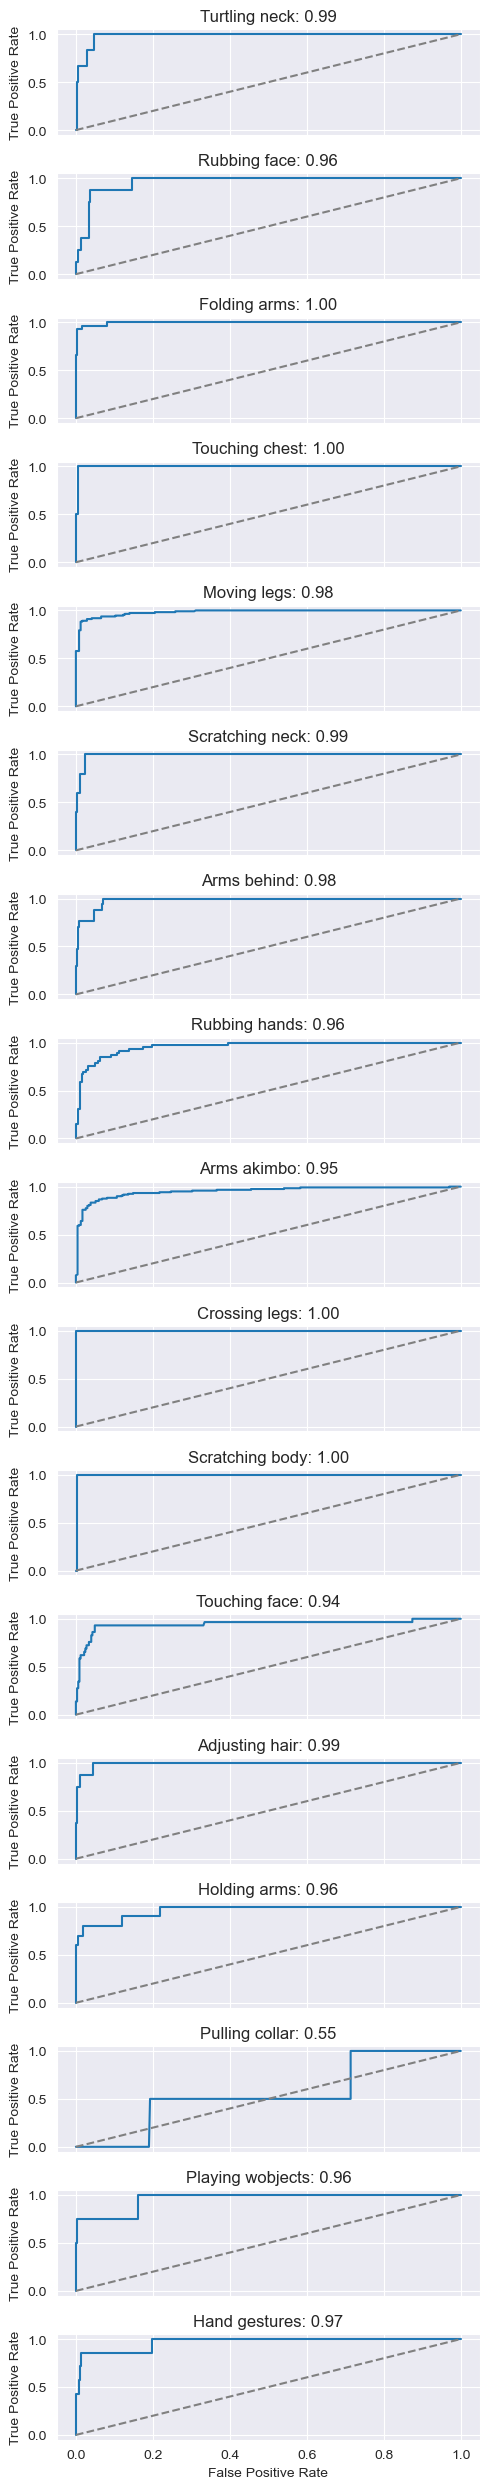

In [166]:
# Plot ROC curves and display additional information
# fig, axes = plt.subplots(nrows=1, ncols=len(roc_metrics), figsize=(15, 5))
num_lables = len(roc_metrics)
fig, axes = plt.subplots(nrows=num_lables, ncols=1, figsize=(5, 25))

for i, (label, metrics) in enumerate(roc_metrics.items()):
    tpr = metrics['tpr']
    fpr = metrics['fpr']
    auc = metrics['auc']
    auc_value = metrics['auc']

    # Plot ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    # Add title, AUC value, and additional information

    # axes[i].set_title(label)
    
    axes[i].set_title(f'{ID2LABELS[int(label)+1]}: {auc_value:.2f}')
    # axes[i].set_title(f'{label}: {auc_value:.2f}')
    # axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    # if i==0:
    if i == num_lables-1:
        # axes[i].set_ylabel('True Positive Rate')
        axes[i].set_xlabel('False Positive Rate')
    # axes[i].legend(loc='lower right')
    else:
        # axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])

    # Add text with additional information
    # axes[i].text(0.5, 0.1, f'True: {true_counts[label]}\nCorrect: {correct_counts[label]}\nMisclassified: {misclassified_counts[label]}',
    #              ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

    

In [167]:
# Gap analysis on lower predictions
detection_th = 0.7
sum_variables = ['micro avg', 'weighted avg','samples avg','macro avg']
bad_features = df_report.loc[df_report['f1-score']<detection_th]
bad_features_list = [a for a in bad_features.index if a not in sum_variables]
print(f'bad features: {bad_features_list}')

good_features = df_report.loc[df_report['f1-score']>=detection_th]
good_features_list = [a for a in good_features.index if a not in sum_variables]
print(f'good features: {good_features_list}')

bad features: ['00-Turtling neck', '01-Rubbing face', '03-Touching chest', '05-Scratching neck', '06-Arms behind', '07-Rubbing hands', '09-Crossing legs', '10-Scratching body', '12-Adjusting hair', '13-Holding arms', '14-Pulling collar', '15-Playing wobjects', '16-Hand gestures']
good features: ['02-Folding arms', '04-Moving legs', '08-Arms akimbo', '11-Touching face']


In [43]:
logits.columns

Index(['logit-0', 'logit-1', 'logit-2', 'logit-3', 'logit-4', 'logit-5',
       'logit-6', 'logit-7', 'logit-8', 'logit-9', 'logit-10', 'logit-11',
       'logit-12', 'logit-13', 'logit-14', 'logit-15', 'logit-16'],
      dtype='object')

In [120]:
selected_feature = '10'
TH = 0.4
temp_df = df_optimal_preds[[selected_feature]].copy()
temp_df = logits[[f'logit-{selected_feature}']].copy()
temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
temp_df['correct'] = (temp_df[selected_feature]>TH) == gt[f'gt-{selected_feature}']
# temp_df['correct'] = (temp_df[selected_feature]) == gt[f'gt-{selected_feature}']
FN = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]
FP = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==0)]
TP = temp_df.loc[(temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]

In [121]:
FP

,10,correct
0006_001_00322-00386_6,0.818359,False


In [122]:
FN

,10,correct


In [123]:
TP

,10,correct
0013_024_04393-04457_10,0.474854,True
0015_020_02923-02987_10,0.564453,True


In [30]:
print(FN.index[0])

/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_02/Cam3/left/0108.mp4


In [81]:
label_to_inspect = 15
print(ID2LABELS[label_to_inspect+1])
cols_to_inspect = [a for a in df.columns if a.split('-')[-1] == str(label_to_inspect)]
df_inspect = df[cols_to_inspect]
df_inspect = df_inspect.rename(columns={a:a.split('-')[0] for a in cols_to_inspect})
df_inspect['pred'] = df_inspect['pred']>0
df_inspect['gt'] = df_inspect['gt']>0


df_inspect['TP'] = (df_inspect['pred']) & (df_inspect['gt'])
df_inspect['FP'] = (df_inspect['pred']) & (~df_inspect['gt'])
df_inspect['FN'] = (~df_inspect['pred']) & df_inspect['gt']
df_inspect['TN'] = (~df_inspect['pred']) & (~df_inspect['gt'])

df_inspect_FN = df_inspect.loc[df_inspect['FP']]
df_inspect_FN

Playing wobjects


,logit,pred,gt,TP,FP,FN,TN
0013_024_04393-04457_10,0.677246,True,False,False,True,False,False


In [112]:
ID2LABELS[8+1]

'Arms akimbo'

In [111]:
df.loc[('0004_116_22287-22351_15'),logit_columns]

logit-0     0.010094
logit-1     0.005844
logit-2     0.001748
logit-3     0.012054
logit-4     0.005405
logit-5     0.000922
logit-6     0.000944
logit-7     0.001285
logit-8     0.380615
logit-9     0.000432
logit-10    0.000586
logit-11    0.034302
logit-12    0.000631
logit-13    0.003651
logit-14    0.000243
logit-15    0.189697
logit-16    0.000117
Name: 0004_116_22287-22351_15, dtype: object

In [10]:
# df.loc['0013_024_04393-04457_10',logit_columns]
feature_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [1]:
from utils import plot_confidence_heatmap

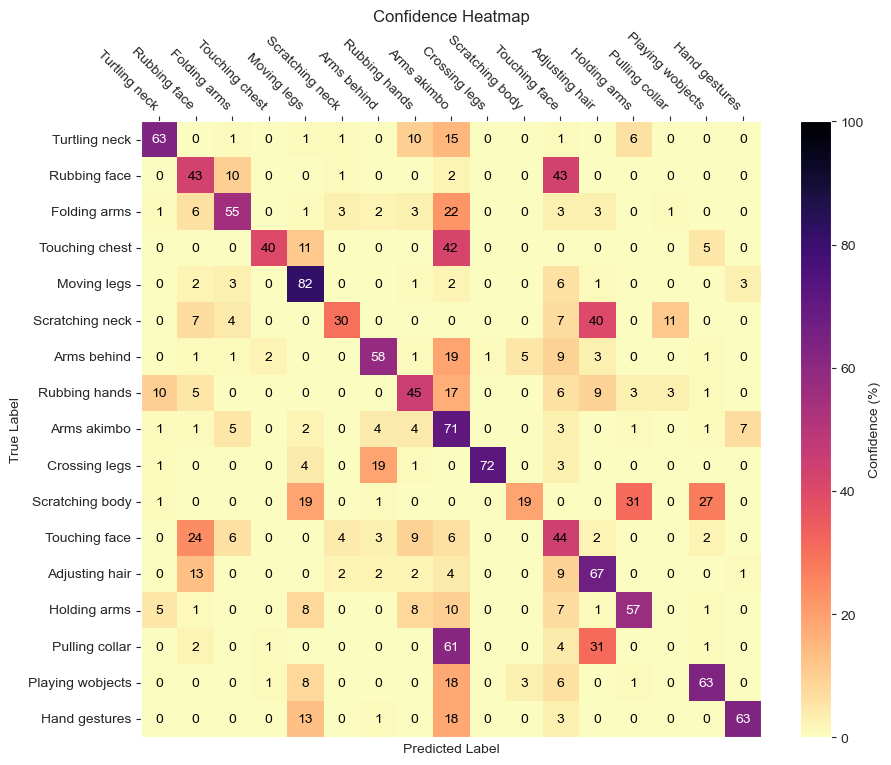

In [14]:
y_true_df = df[gt_columns].values
# y_true_df = y_true_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_true_df.columns})
y_pred_df = df[logit_columns].values
# y_pred_df = y_pred_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_pred_df.columns})

plot_confidence_heatmap(y_true_df, y_pred_df, ID2LABELS.values())